# PRACTICAL LECTURE 4

# PART1. Autoencoders

1. Import libraries

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

2. Convert vector to image.
The following function allows to convert a vector to a image


In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

3. We now write a function which allows to display the images using the omshow() function.

In [ ]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

4. Define a data loading step and load the MNIST dataset

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataloader

5. Fix the used device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6. Define the Autoencoder model architecture and reconstruction loss
with : 
n = 28 x 28 = 784

A. Use d = 30  for standard AE (under-complete hidden layer)

B. Use d = 500 for denoising AE (over-complete hidden layer)

C. Explain the difference between standard AE and denoising AE.
Analyse the results and conclude.


In [21]:
d=30;

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

7. Configure the optimiser. We use here : learning_rate equals to 1e-3

In [22]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

8. Train the standard autoencoder and the denoising autoencoder using the following code :


epoch [1/20], loss:0.1095
epoch [2/20], loss:0.1068
epoch [3/20], loss:0.1003
epoch [4/20], loss:0.0975
epoch [5/20], loss:0.1009
epoch [6/20], loss:0.0967
epoch [7/20], loss:0.0912
epoch [8/20], loss:0.0940
epoch [9/20], loss:0.0902
epoch [10/20], loss:0.0890
epoch [11/20], loss:0.0886
epoch [12/20], loss:0.0905
epoch [13/20], loss:0.0880
epoch [14/20], loss:0.0828
epoch [15/20], loss:0.0836
epoch [16/20], loss:0.0841
epoch [17/20], loss:0.0856
epoch [18/20], loss:0.0851
epoch [19/20], loss:0.0891
epoch [20/20], loss:0.0836


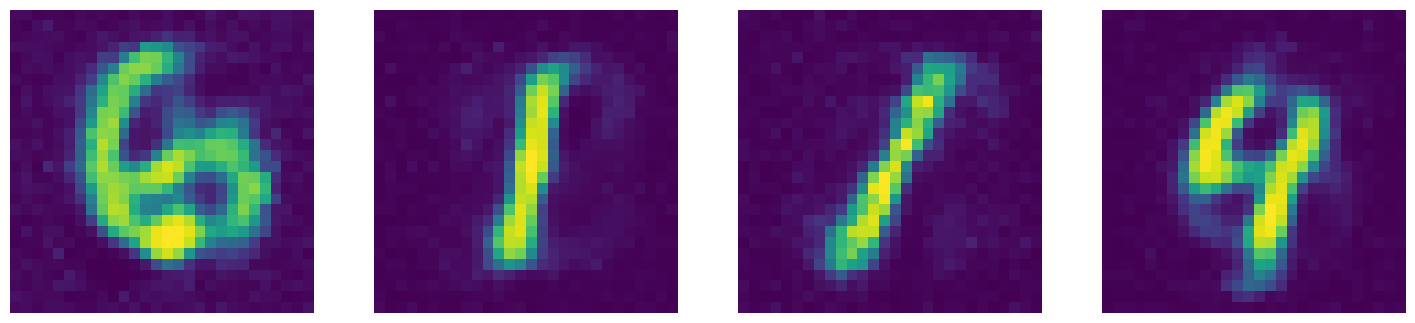

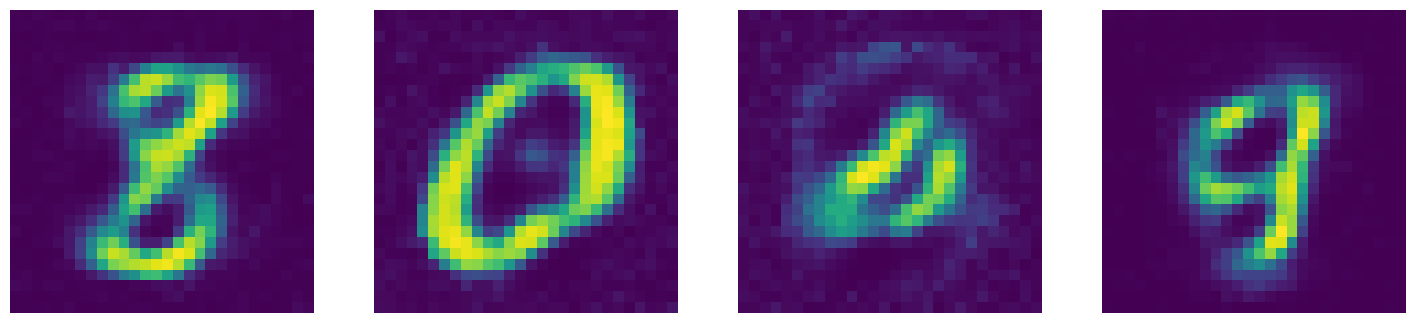

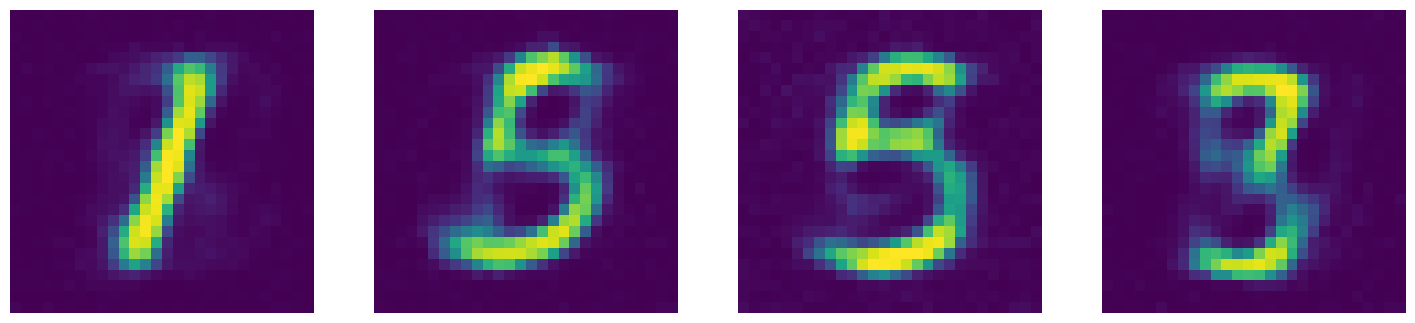

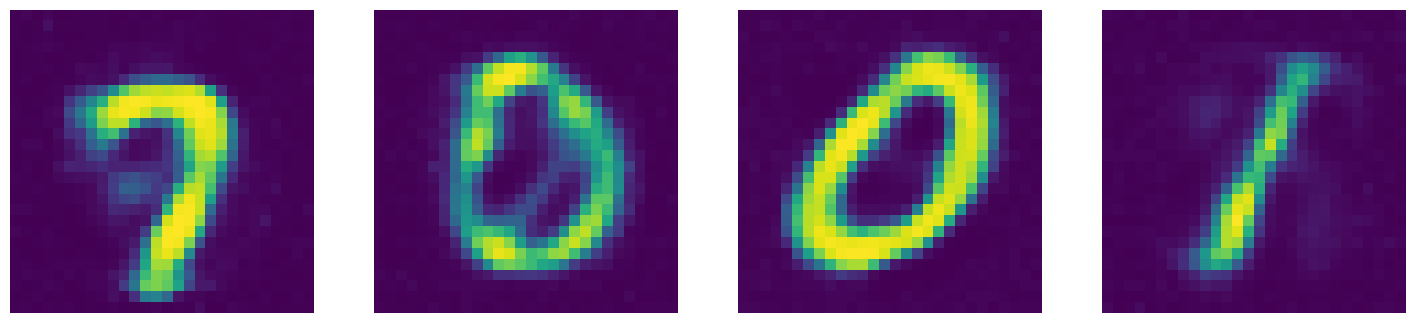

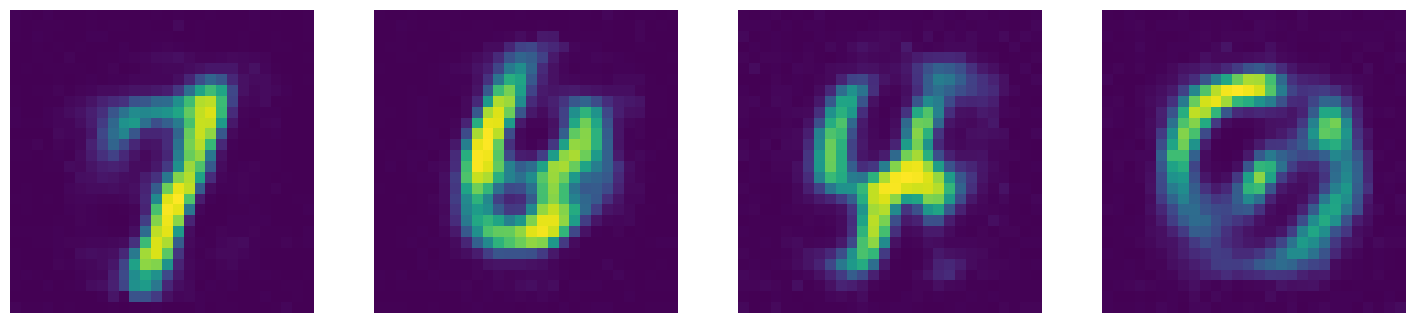

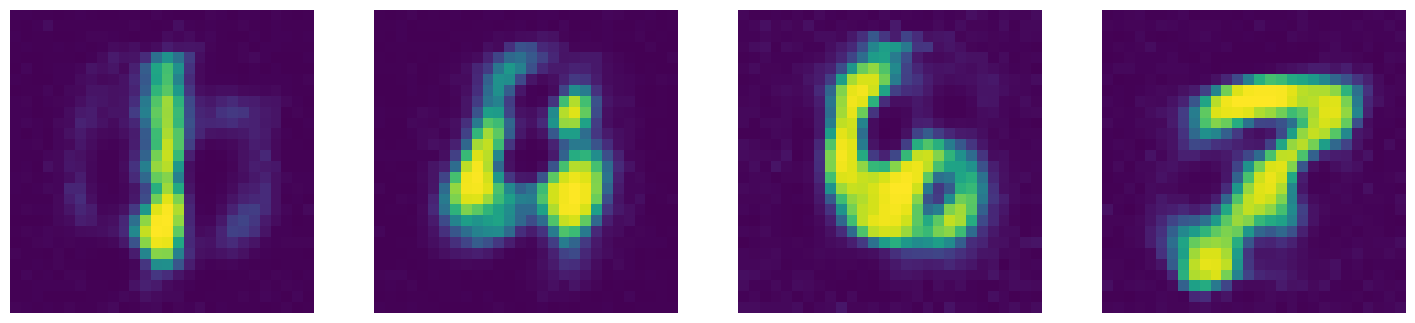

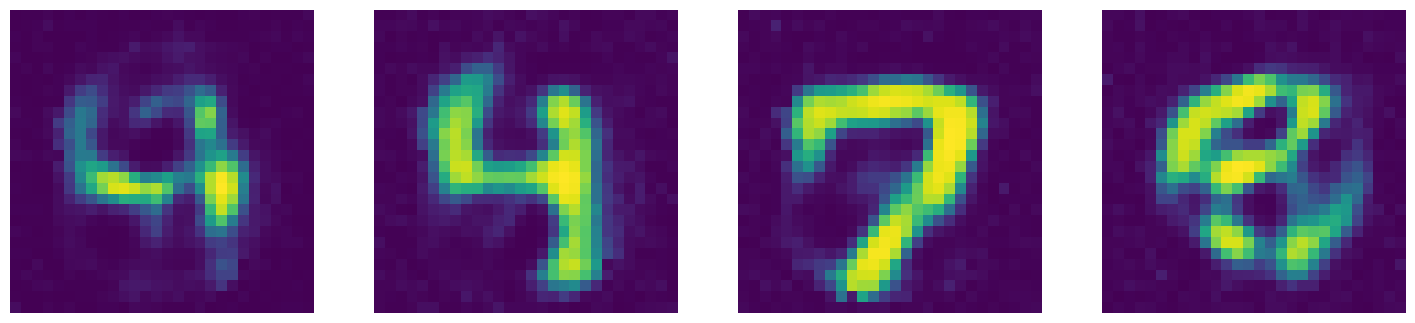

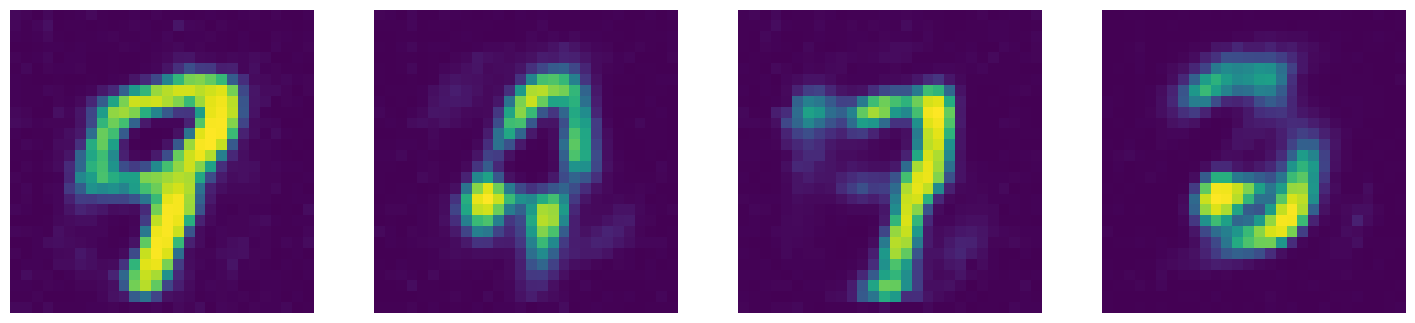

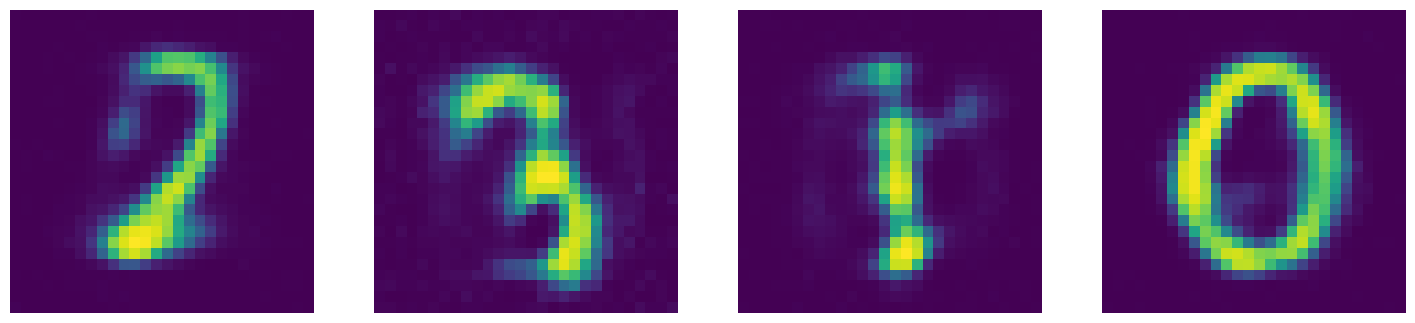

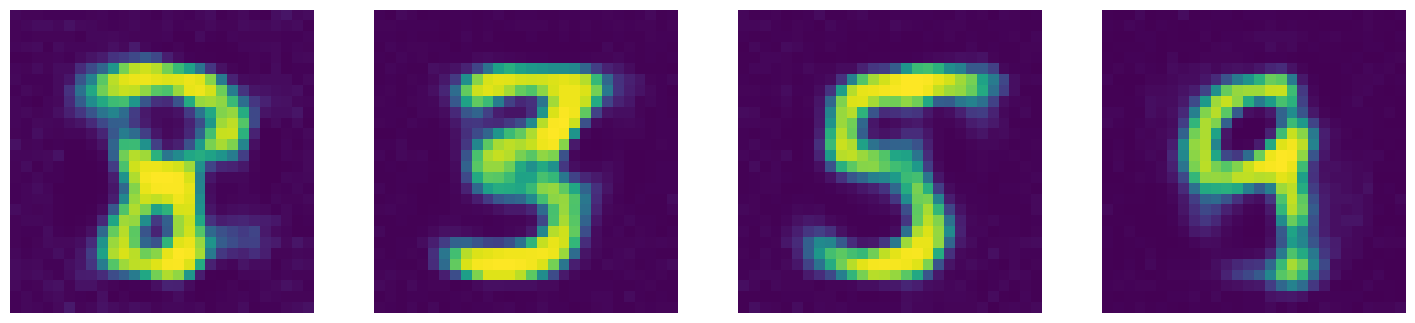

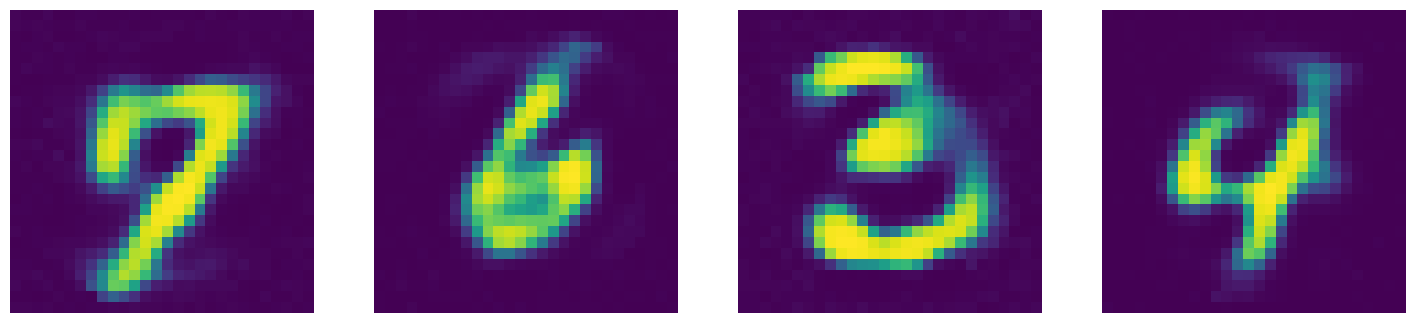

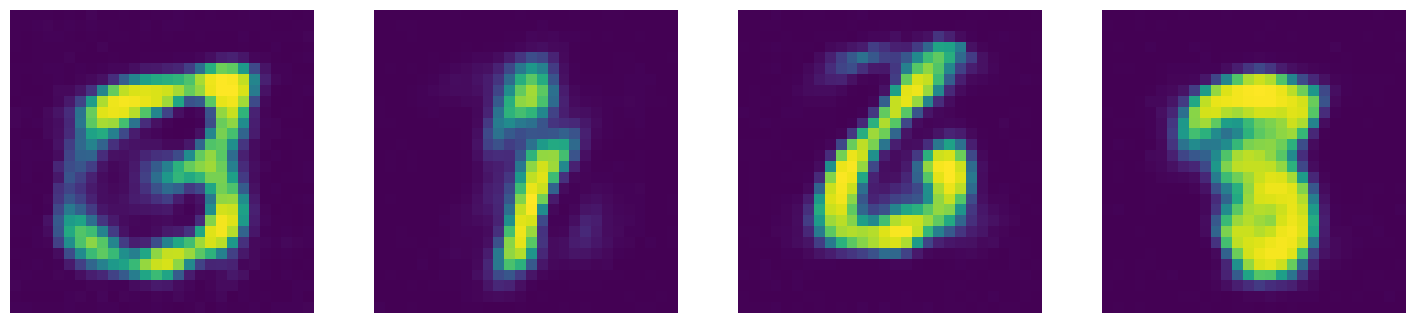

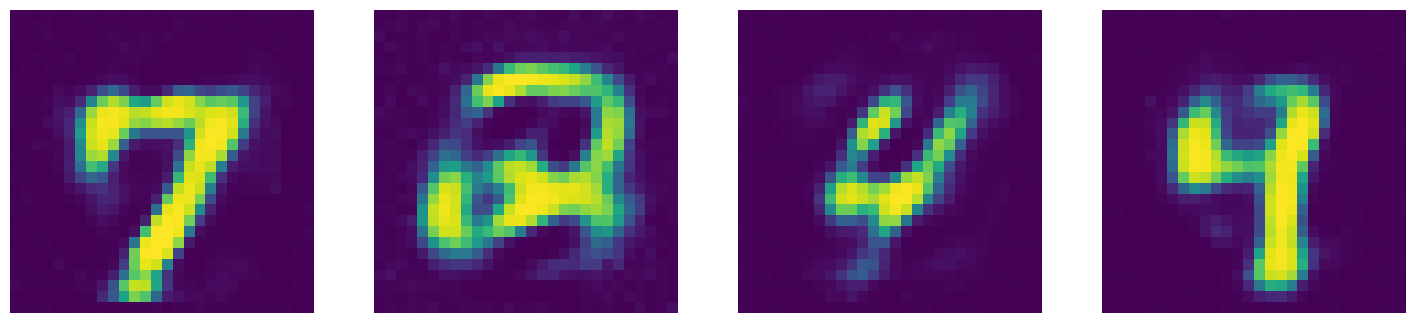

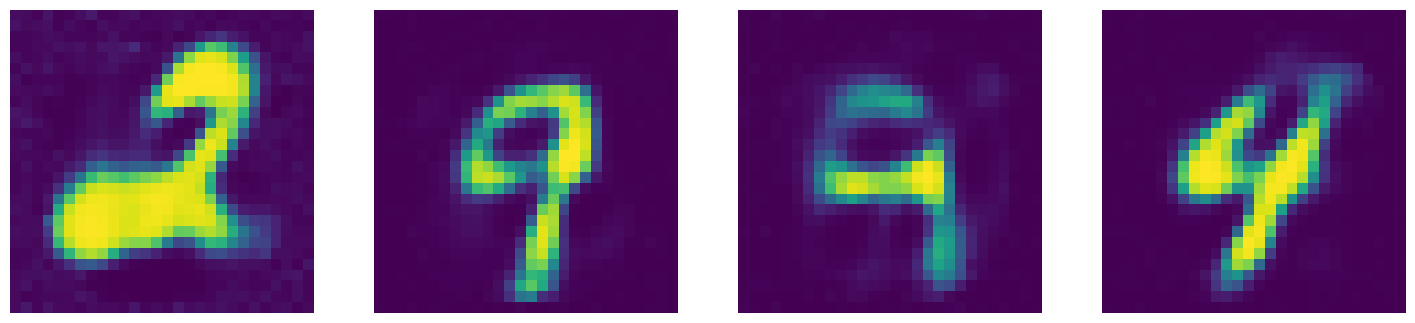

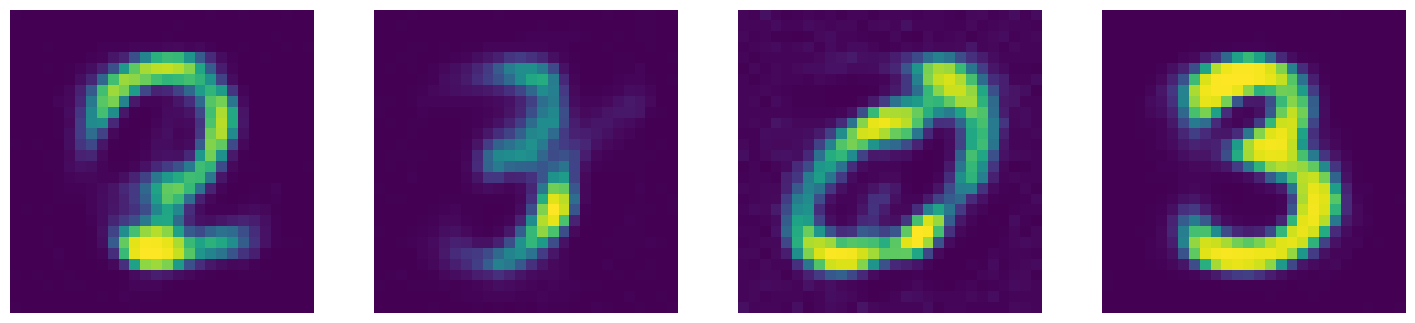

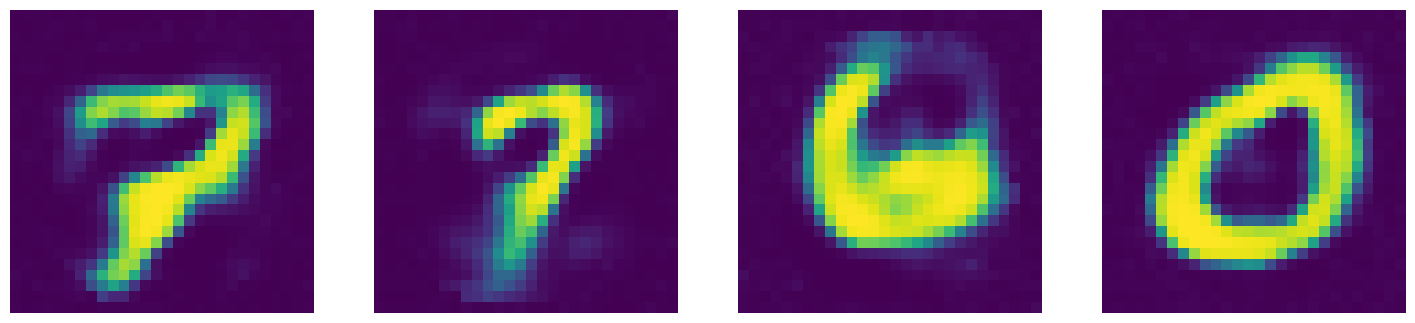

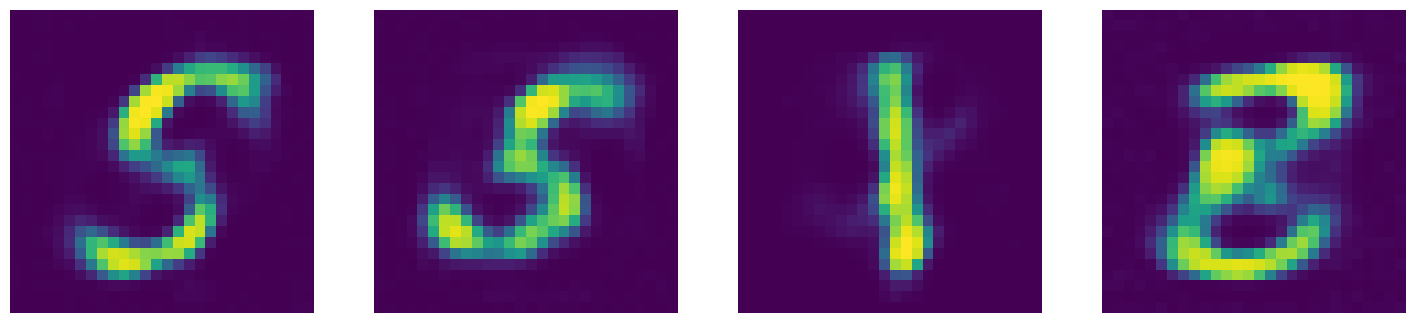

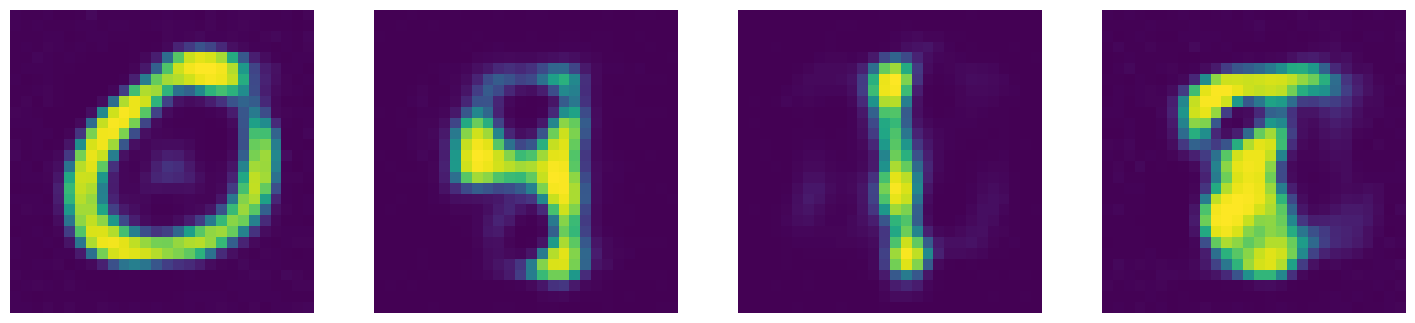

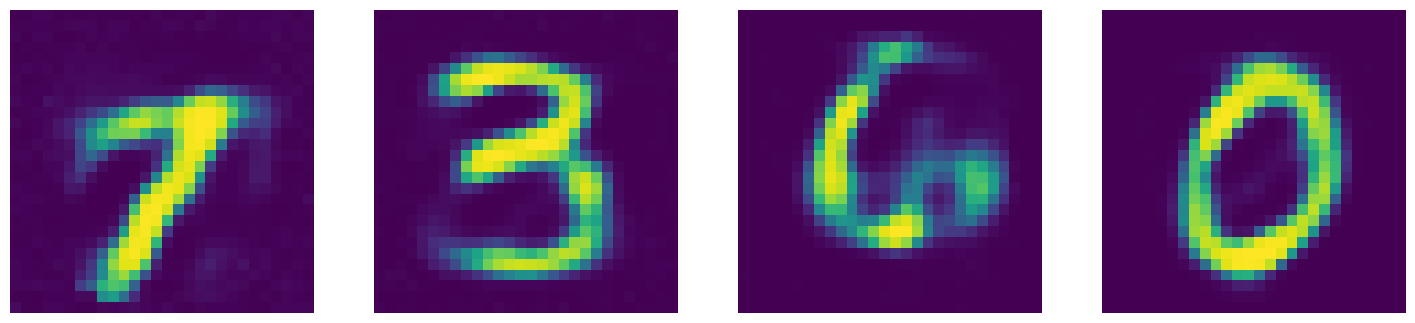

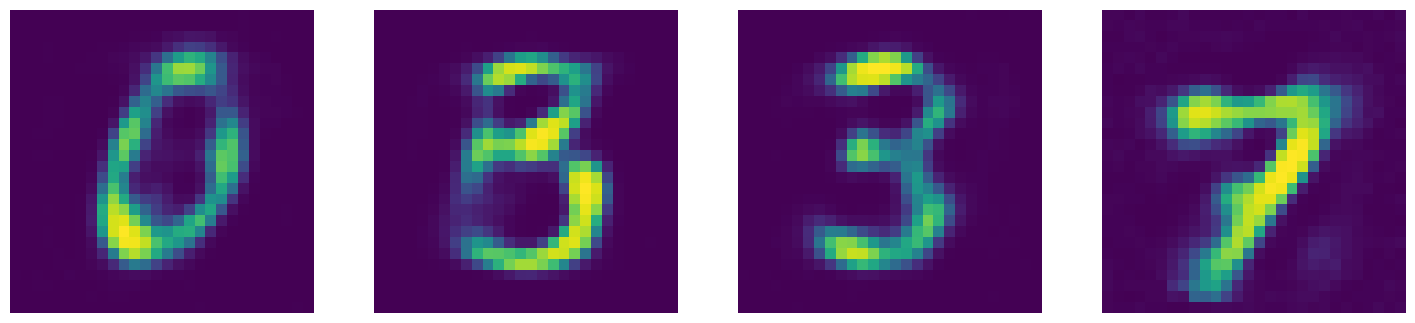

In [26]:
num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

9. Visualise a few kernels of the encoder :


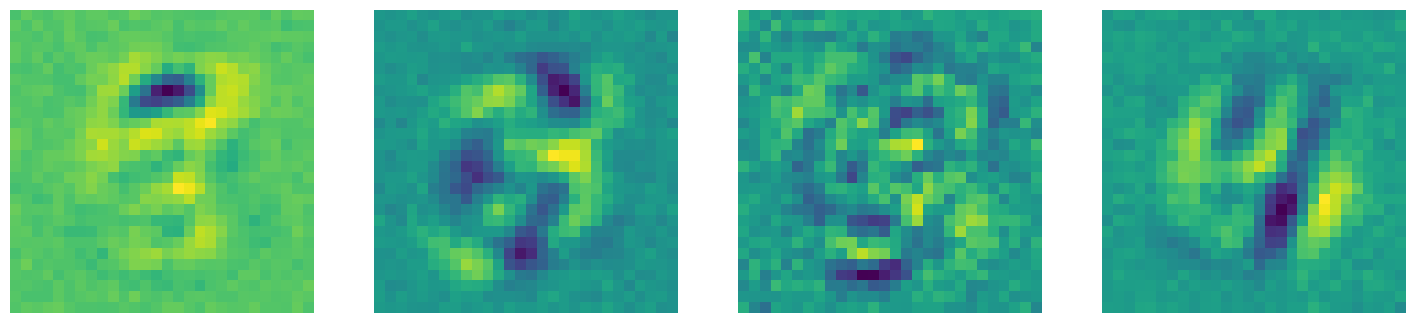

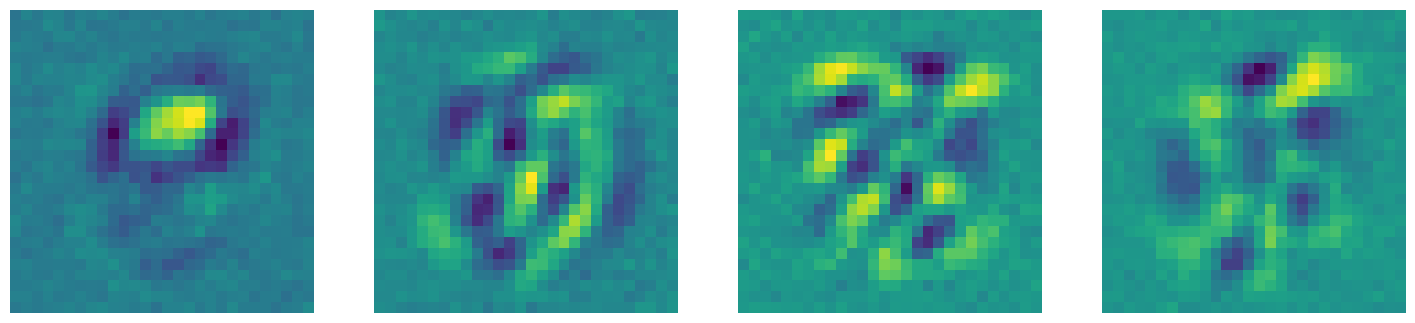

In [32]:
display_images(None, model.encoder[0].weight, 2)

10. Analyse the obtained results.

11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.

 ====  d=10 epcohs=20 learning_rate=0.001 ====
epoch [1/20], loss:0.2853
epoch [2/20], loss:0.2631
epoch [3/20], loss:0.2274
epoch [4/20], loss:0.2256
epoch [5/20], loss:0.2059
epoch [6/20], loss:0.2020
epoch [7/20], loss:0.1900
epoch [8/20], loss:0.1829
epoch [9/20], loss:0.1732
epoch [10/20], loss:0.1610
epoch [11/20], loss:0.1740
epoch [12/20], loss:0.1685
epoch [13/20], loss:0.1656
epoch [14/20], loss:0.1650
epoch [15/20], loss:0.1439
epoch [16/20], loss:0.1564
epoch [17/20], loss:0.1524
epoch [18/20], loss:0.1588
epoch [19/20], loss:0.1516
epoch [20/20], loss:0.1588


 ====  d=20 epcohs=20 learning_rate=0.001 ====
epoch [1/20], loss:0.2525
epoch [2/20], loss:0.2004
epoch [3/20], loss:0.1746
epoch [4/20], loss:0.1731
epoch [5/20], loss:0.1526
epoch [6/20], loss:0.1457
epoch [7/20], loss:0.1233
epoch [8/20], loss:0.1260
epoch [9/20], loss:0.1348
epoch [10/20], loss:0.1182
epoch [11/20], loss:0.1168
epoch [12/20], loss:0.1182
epoch [13/20], loss:0.1083
epoch [14/20], loss:0.1180
epoc

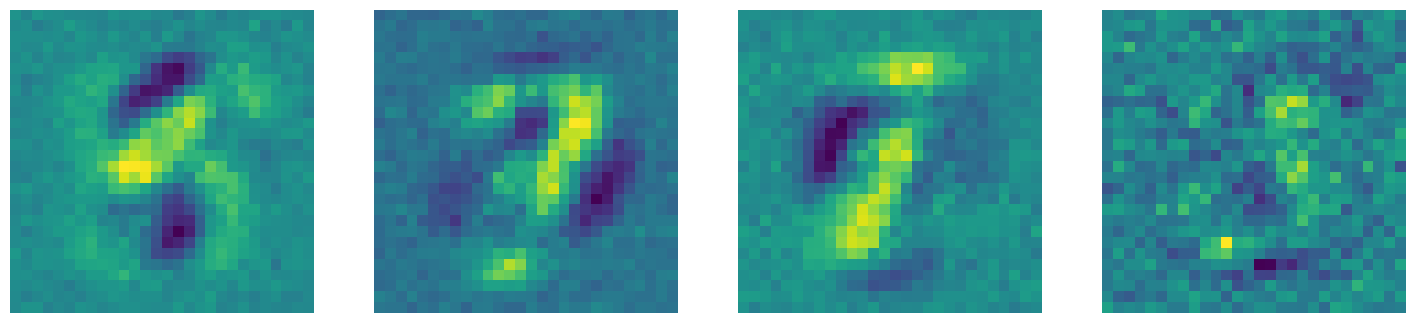

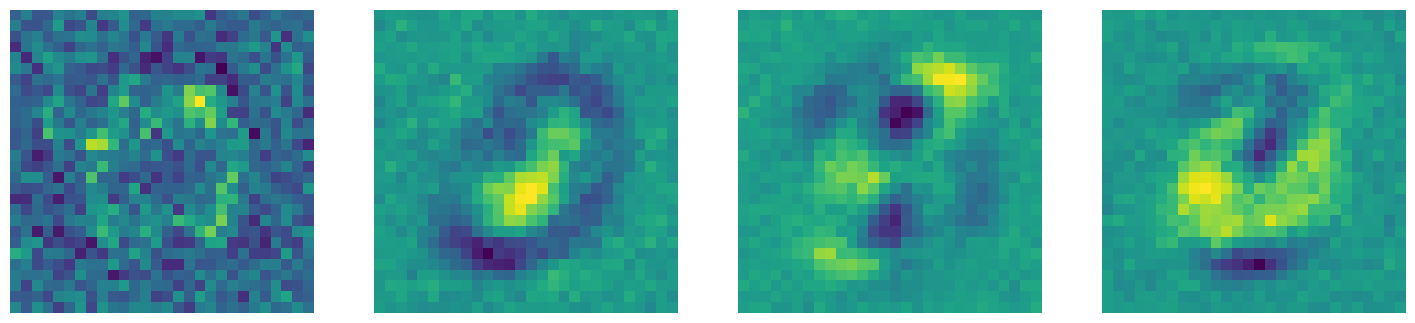

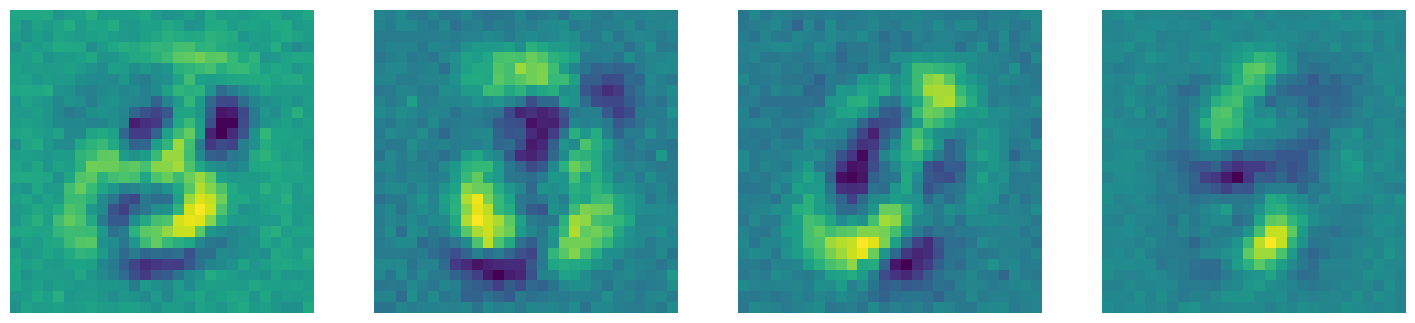

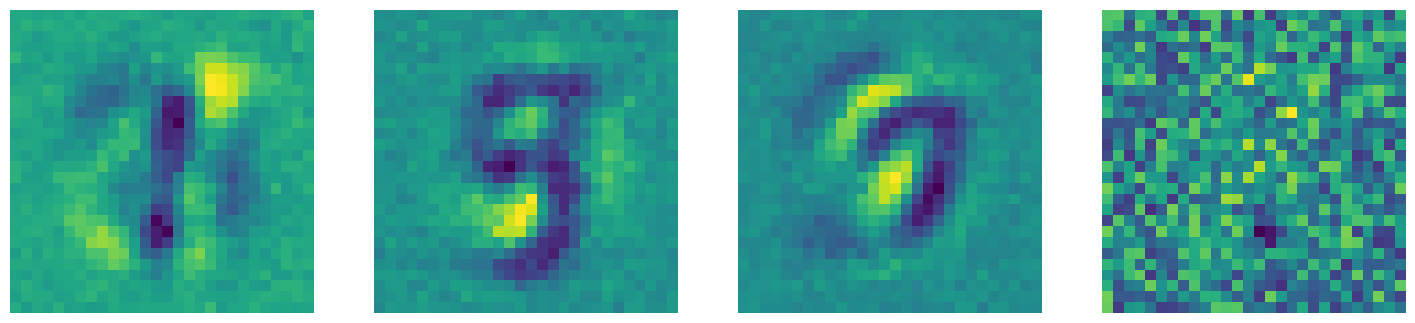

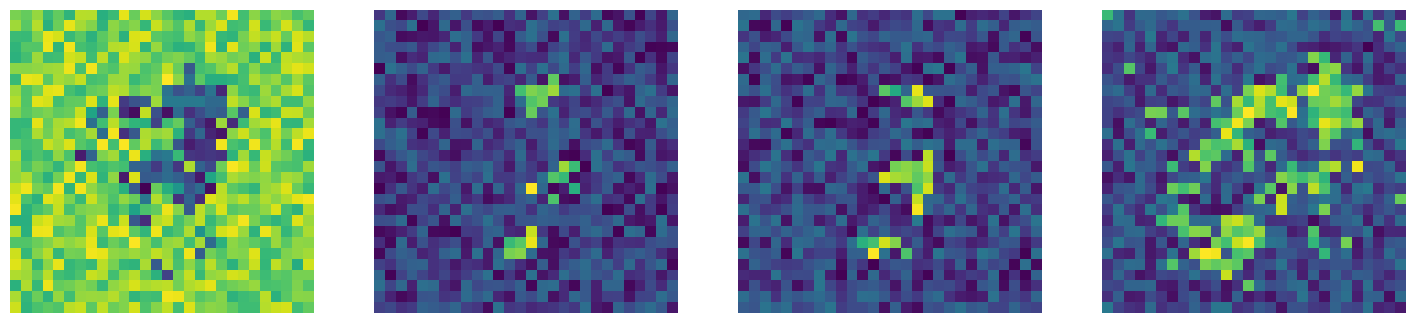

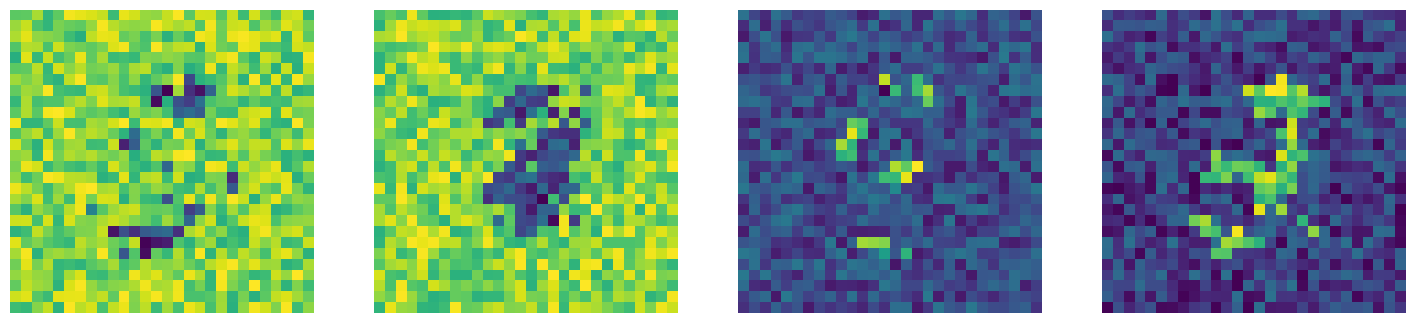

In [34]:
#'(d,epoch,learning_rate)
params = [(10,20,1e-3), (20,20,1e-3),(30,30,1e-2)]
for param in params:
    d,epochs,lr = param
    print(f" ====  d={d} epcohs={epochs} learning_rate={lr} ====")
    
    model = Autoencoder().to(device)
    optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    )
    
    num_epochs = epochs
    do = nn.Dropout()  # comment out for standard AE
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            noise = do(torch.ones(img.shape)).to(device)
            img_bad = (img * noise).to(device)  # comment out for standard AE
            # ===================forward=====================
            output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
            loss = criterion(output, img.data)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
        #display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE
    display_images(None, model.encoder[0].weight, 2)
    print("\n======================= \n")

Layer 1: loss 0.15 <br>
Layer 2: loss 0.11 <br>
Layer 3: loss 0.28 <br>
From this information, we can make the following observations:<br>

The reconstruction loss decreases as the autoencoder is trained with more epochs and larger hidden layers. This is expected, as the autoencoder is learning to reconstruct the input data more accurately as it has more capacity and is given more time to learn.<br>

The learning rate is higher for the third layer compared to the first two layers. This may have contributed to the higher reconstruction loss for the third layer, as a high learning rate can make the training unstable and cause the loss to oscillate or even increase.<br>

The reconstruction loss of the second layer is the lowest among the three layers, which suggests that it may be the most effective layer in capturing the important features of the input data.<br>

Overall, these results suggest that increasing the capacity of the autoencoder and training it for more epochs can lead to better reconstruction performance, but care should be taken when setting the learning rate to avoid instability in the training process.<br>

